# `Story: in-vitro screening -> virtual screening`
Virtual screening is a computational technique used to identify potential drug candidates in the early stages of drug discovery.<br>
It involves the screening of large chemical libraries to identify compounds that are likely to bind to a target protein.

This came as a solution to the traditional method of drug discovery, which involves the screening of chemical libraries in the laboratory to identify compounds that bind to a target protein.

This process can be time-consuming and expensive, as it requires the synthesis and testing of a large number of molecules.

#### In-vitro:
1. combine a protein with a chemical compound
2. measure the binding affinity of the compound to the protein
3. repeat for a large number of compounds
4. select the compounds with the highest binding affinity
5. synthesize the selected compounds
6. proceed to in-vivo testing

`Virtual Screening `can be used to reduce the number of compounds that need to be tested in the laboratory, which are steps 1-4.

# `Reading and understanding the data`

In [ ]:
import sys
sys.path.insert(0, '..')

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import rdkit
from rdkit import Chem

from chemception.model_transfer import Chemception
from chemception.featurizer import ChemCeptionizer

import tensorflow as tf
import keras.backend as K
tf.compat.v1.disable_eager_execution()

train_df = pd.read_csv('../data/train_aid686978_0.7.csv')
train_df.head()

`SMILES` are a way to represent molecules as strings **(O=C(c1cc2c(=O)n3ccccc3nc2s1)N1CCOCC1)**

 This represenation is a standard in the Chemistry community and is usually parsed to other representaions of the molecule. For example, the `RDKit` library can parse SMILES to a `Mol` object.

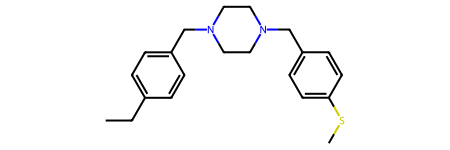

In [329]:
Chem.MolFromSmiles(train_df['smiles'].iloc[0])

We will use this represntation as a first step for our featurization. 

We will use the `RDKit` library to parse the SMILES to a `Mol` object for all the data.

In [330]:
train_df["mol"] = train_df["smiles"].apply(Chem.MolFromSmiles)

# `Featurizing`

The featurization process plays a crucial role in our adopted paper, as it carefully selects features that effectively describe the molecule and incorporates them into the model. This approach aligns with our understanding of feature selection for our own data.

Given that we are employing a CNN model, our featurization method relies on an image representation of the molecule. However, we also perform feature engineering to extract essential characteristics such as `bond order,` `atom types,` `hybridization,` and `Gasteiger charges.` These extracted features are then utilized in our model to enhance its performance.

![Alt text](../images/Featurizer.png)

In [ ]:
# This is the featurizer we used, can be found in chemception/featurizer.py
featureizer = ChemCeptionizer(embed=20, fuse=True)

# Featurize the molecules
train_df["molimage"] = train_df["mol"].apply(featureizer.featurize)

### `Visualize the results of the featurization process`

Text(0.5, 1.0, 'Hybridization Channel')

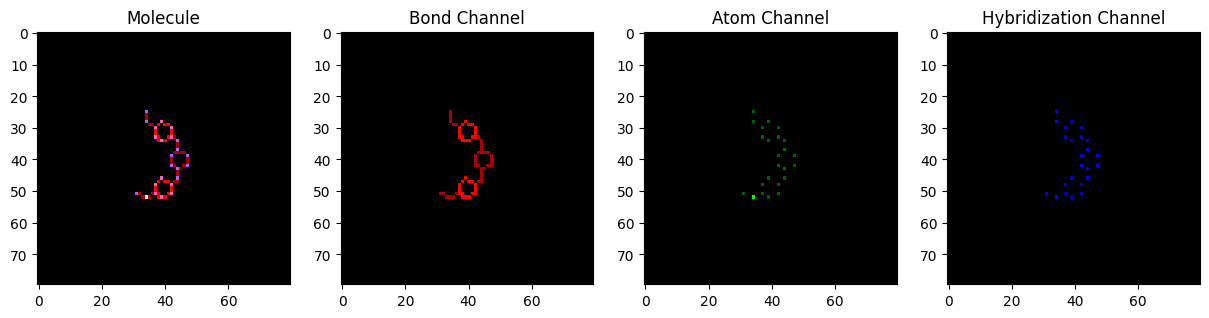

In [332]:
def show_channel(v, channel_ind):
    """
    Returns a copy of the molecule image with only the specified channel
    """
    v_copy = np.zeros(shape=(v.shape[0], v.shape[1], 3))
    v_copy[:,:,channel_ind] = v[:,:,channel_ind]/ np.max(v[:,:,channel_ind])
    return v_copy


sample = train_df["molimage"].iloc[0]
ch1, ch2, ch3 = show_channel(sample, 0), show_channel(sample, 1), show_channel(sample, 2)
fig, ax = plt.subplots(1, 4, figsize=(15, 15))
ax[0].imshow(sample)
ax[1].imshow(ch1)
ax[2].imshow(ch2)
ax[3].imshow(ch3)
ax[0].set_title("Molecule")
ax[1].set_title("Bond Channel")
ax[2].set_title("Atom Channel")
ax[3].set_title("Hybridization Channel")


The featurization is working correctly, we proceed to model building

# `Preparing generator and data for fitting`

![Alt text](../images/Featurizer.png) <br>


By examining the image above, we can clearly observe the disparity in orientation between the original image and the result of our featurization process. As our featurization method involves reconstructing the molecule image based on the selected features, we can confidently assert that there is negligible intra-class variation, rendering augmentation unnecessary.

In [333]:
from keras.preprocessing.image import ImageDataGenerator

# create a generator that returns batches of size 256
generator = ImageDataGenerator(data_format='channels_last')

train_df.dropna(subset=["molimage"], inplace=True)
X_train = train_df["molimage"].to_numpy()
X_train = np.stack(X_train, axis=0)
y_train = train_df["label"].to_numpy()


indeces_where_nan = np.any(np.isnan(X_train), axis=(1, 2, 3))
X_train = X_train[~indeces_where_nan]
y_train = y_train[~indeces_where_nan]

batch_size=256
g = generator.flow(X_train, y_train, batch_size=batch_size, shuffle=True)

#### Define a pipeline for the data

In [334]:
def data_featurizer(df, return_df=False):
    
    """
    takes a dataframe with smiles and labels and returns a numpy array of the featurized images and a numpy array of the labels
    """
    df["mol"] = df["smiles"].apply(Chem.MolFromSmiles)
    df["molimage"] = df["mol"].apply(featureizer.featurize)
    df = df.dropna(subset=["molimage"])
    
    X = df["molimage"].to_numpy()
    X = np.stack(X, axis=0)
    y = df["label"].to_numpy()
    
    # remove any rows with nan values
    indeces_where_nan = np.any(np.isnan(X), axis=(1, 2, 3))
    X = X[~indeces_where_nan]
    y = y[~indeces_where_nan]
    
    if return_df:
        df = df[~indeces_where_nan]
        return X, y, df
    else:
        return X, y

# `Building the model`

### `Challenges`

Considering our resource limitations, we have decided to utilize a CNN model with an `InceptionV3` architecture as our base model. It is worth noting that our choice of model architecture, `Chemception`, is heavily `influenced` by the InceptionV3 model.

To construct our feature set, we will incorporate important aspects of the molecule, including `bonds_order`, `atom_types`, `hybridization`, and `gasteiger_charges`. These features will be used as inputs for our model, enabling it to capture the relevant characteristics of the molecules effectively.

As mentioned previously, we encountered a challenge while using the InceptionV3 model, as it was originally trained on RGB images. Since our featurization process resulted in four features, we needed to find a way to convert them into RGB images. We explored two options to address this issue:
1. The first option involved discarding the last feature, gasteiger_charges, and utilizing the remaining three features as RGB images. However, this approach would result in the loss of a valuable feature.

2. The second option we considered was employing weighted fusion to combine all four features into a single RGB image. By doing so, we could preserve the valuable feature and introduce significant variations in the resulting images.
After careful consideration, we opted for the second option. The following images demonstrate the transformation:

Before:
<br><br>
<div>
<img src="../images/Featurizer.png" width="800"/>
</div><br><br><br>
After:
<br><br>
<div>
<img src="../images/after_fusion.png" width="800"/>
</div>

By employing the weighted fusion technique, we successfully converted our feature set into an RGB image representation that could be effectively utilized by the InceptionV3 model.

### `hyperparameters optimization`
We used hyperband and bayesian optimization to find the best hyperparameters for our model.

We used the `hpbandster` library for the and results can be found in the **./hpbandster_opt/visualizer.ipynb** notebook.
<br>
<br>
<div>
<img src="../images/hpbandster.png" width="500"/>
</div><br>
<br>

| Hyperparameter   | Value  |
|-----------------|--------|
| dense_layers    | 1      |
| dropout         | 0.1    |
| lr              | 0.0001 |
| neurons         | 128    |

In [335]:
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import plot_model

model = Chemception(neurons=128, dropout=0.1, dense_layers=1)
model = model.build()
# Compile the model with binary cross-entropy loss and Adam optimizer
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

2023-05-07 01:16:40.378116: W tensorflow/c/c_api.cc:300] Operation '{name:'conv2d_173/kernel/Assign' id:147070 op device:{requested: '', assigned: ''} def:{{{node conv2d_173/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](conv2d_173/kernel, conv2d_173/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None, 80, 80, 3)]  0           []                               
                                                                                                  
 conv2d_94 (Conv2D)             (None, 39, 39, 32)   864         ['input_21[0][0]']               
                                                                                                  
 batch_normalization_103 (Batch  (None, 39, 39, 32)  96          ['conv2d_94[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation_94 (Activation)     (None, 39, 39, 32)   0           ['batch_normalization_103[0

# `Fitting the model`

#### Load validation data

In [ ]:
# val_df = pd.read_csv('../data/val_aid686978_0.7.csv')
# X_val, y_val = data_featurizer(val_df)

#### With early stopping

In [337]:
# from keras.callbacks import EarlyStopping
# early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='auto', restore_best_weights=True)
# model.fit(g, epochs=100, steps_per_epoch=len(X_train)/batch_size, validation_data=(X_val, y_val), callbacks=[early_stopping], verbose=1)
# model.save('chemception_transfer_preprocess.h5')

# `Load the model after training`

In [ ]:
from keras.models import load_model
import tensorflow as tf

model = load_model('../models/chemception_transfer.h5')

# `Test the model on test data`

In [ ]:
test_df = pd.read_csv('../data/test_aid686978_0.7.csv')
X_test, y_test, test_df = data_featurizer(test_df, return_df=True)

### `ROC curve`

We could not find other papers that have done studies on the same dataset, but a similar test was done in the `'HIV'` dataset. ROC scores are the following `(~0.74)`
adjust the size of the image
<br><br>
<div>
<img src="../images/hiv_roc.png" width="500"/>
</div>

/opt/miniconda3/lib/python3.9/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-05-07 01:17:45.595600: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_1_2/Sigmoid' id:157084 op device:{requested: '', assigned: ''} def:{{{node dense_1_2/Sigmoid}} = Sigmoid[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_1_2/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


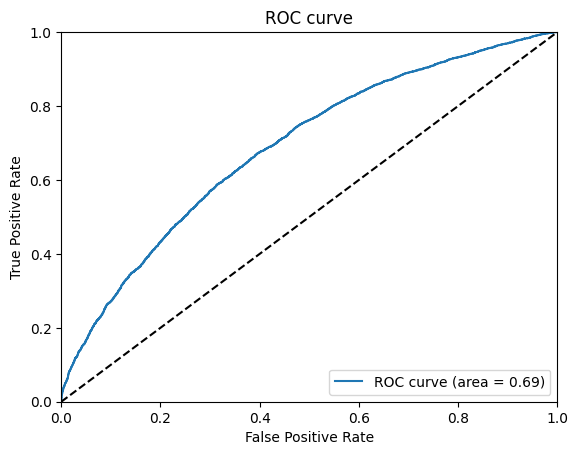

In [340]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

y_pred = model.predict(X_test)
y_pred = y_pred.flatten()
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

### We got a `ROC` of `0.69` which is great given the available resources.

# `Kernel Visualization`

Kernel visualization is a technique that helps domain experts under the model's decision making process.

It is a great tool for debugging and understanding the model.

/opt/miniconda3/lib/python3.9/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-05-07 01:18:05.153125: W tensorflow/c/c_api.cc:300] Operation '{name:'conv2d_188/Conv2D' id:149850 op device:{requested: '', assigned: ''} def:{{{node conv2d_188/Conv2D}} = Conv2D[T=DT_FLOAT, _has_manual_control_dependencies=true, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 2, 2, 1], use_cudnn_on_gpu=true](input_1_3, conv2d_188/Conv2D/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


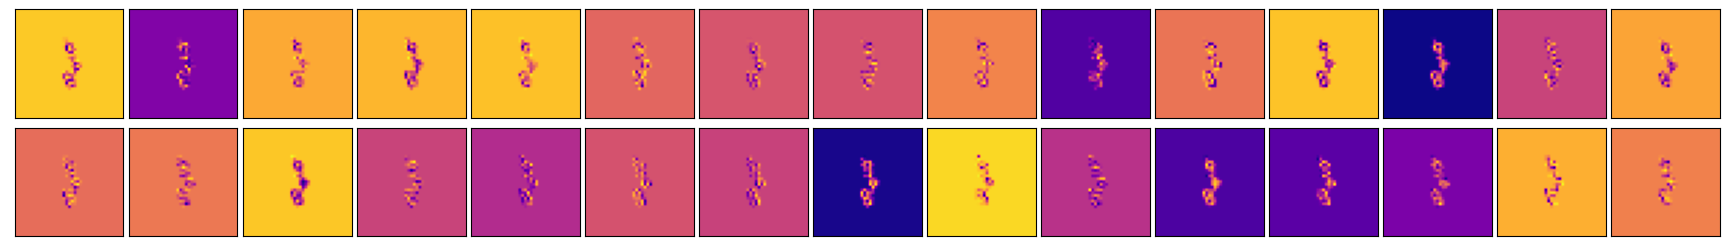

In [341]:
layer_outputs = [layer.output for layer in model.layers[1:100]]

img = X_test[0]
img = np.expand_dims(img, axis=0)

activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(img)

layer_names = ['conv2d_1', 'activation_1', 'conv2d_4', 'activation_4', 'conv2d_9', 'activation_9']
activ_list = [activations[0], activations[2], activations[10], activations[12], activations[17], activations[19]]

fig = plt.figure(figsize=(22, 3))
for img in range(30):
    ax = fig.add_subplot(2, 15, img+1)
    ax = plt.imshow(activations[0][0, :, :, img], cmap='plasma')
    plt.xticks([])
    plt.yticks([])
    fig.subplots_adjust(wspace=0.05, hspace=0.05)

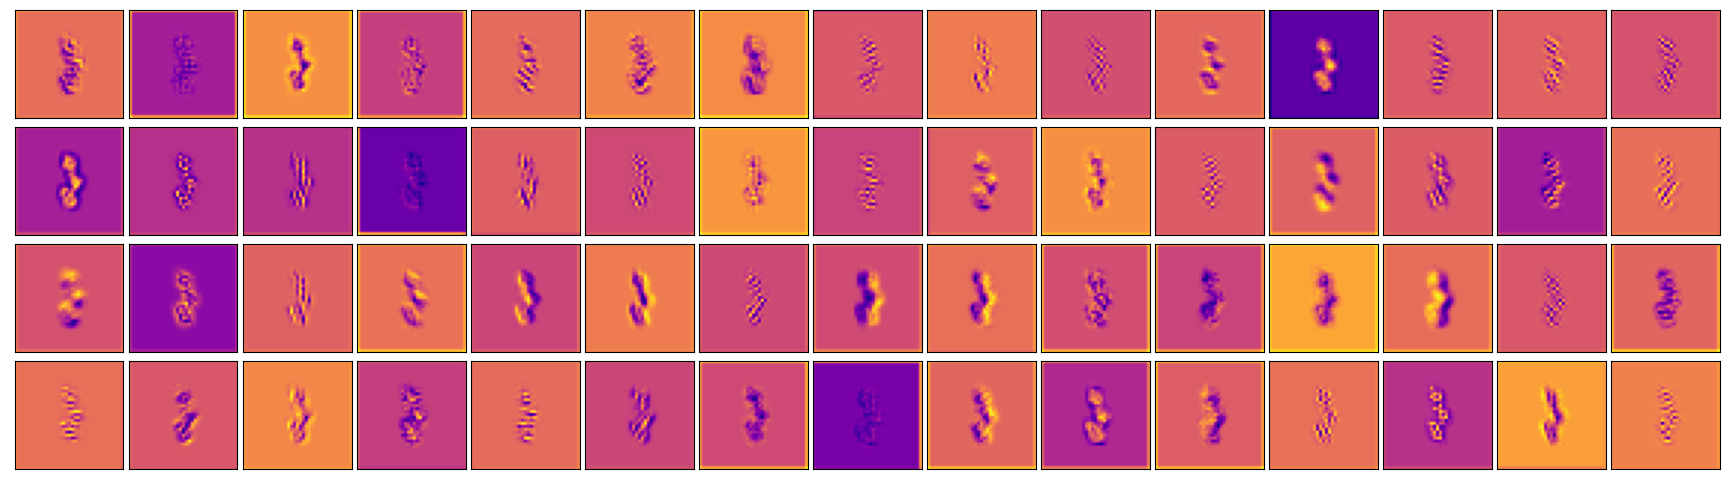

In [342]:
fig = plt.figure(figsize=(22, 6))
for img in range(60):
    ax = fig.add_subplot(4, 15, img+1)
    ax = plt.imshow(activations[6][0, :, :, img], cmap='plasma')
    plt.xticks([])
    plt.yticks([])
    fig.subplots_adjust(wspace=0.05, hspace=0.05)

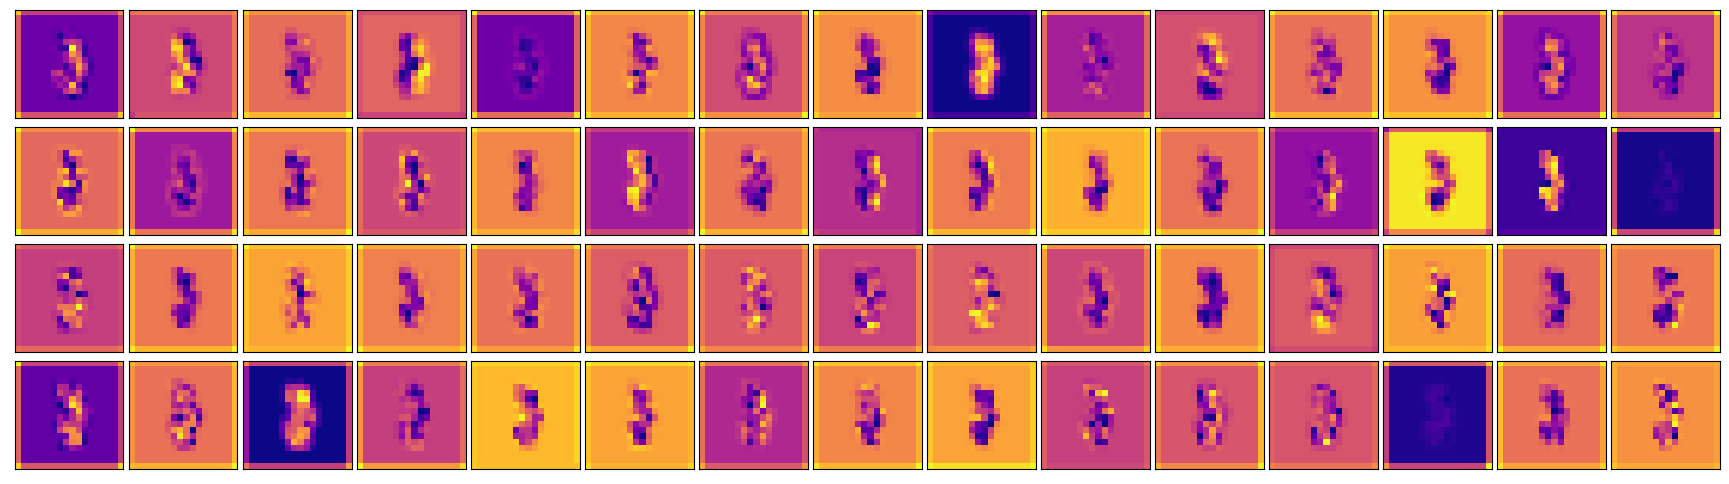

In [343]:
fig = plt.figure(figsize=(22, 6))
for img in range(60):
    ax = fig.add_subplot(4, 15, img+1)
    ax = plt.imshow(activations[10][0, :, :, img], cmap='plasma')
    plt.xticks([])
    plt.yticks([])
    fig.subplots_adjust(wspace=0.05, hspace=0.05)

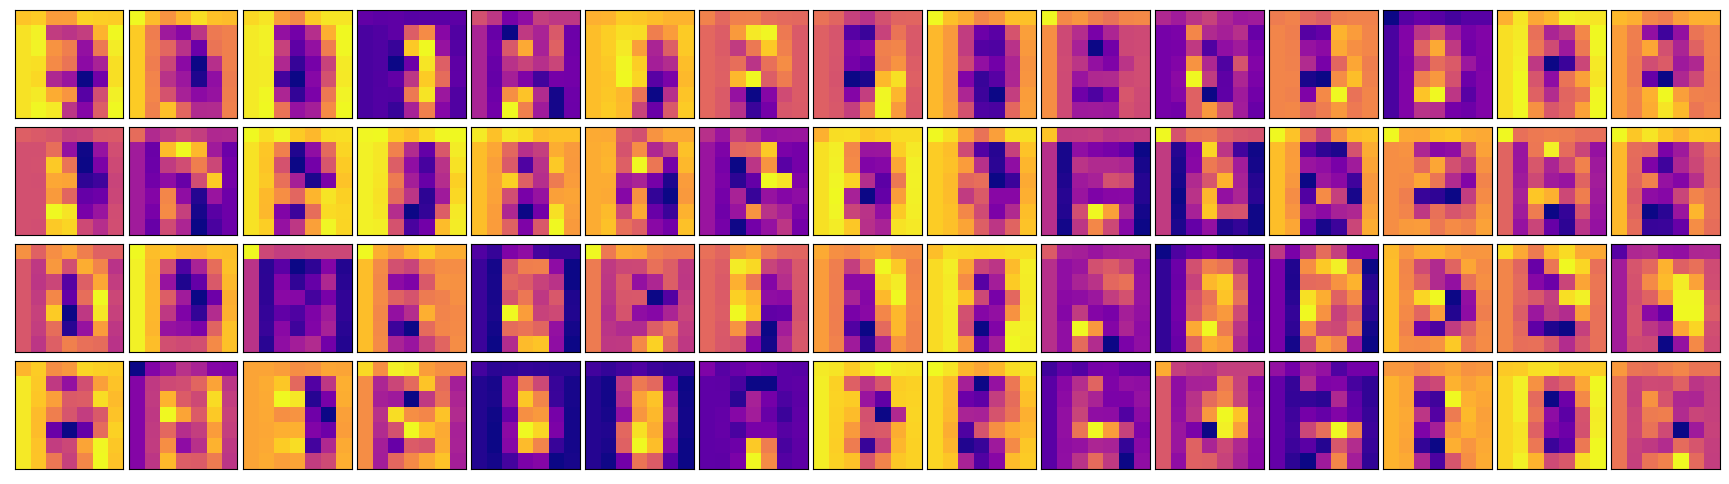

In [344]:
fig = plt.figure(figsize=(22, 6))
for img in range(60):
    ax = fig.add_subplot(4, 15, img+1)
    ax = plt.imshow(activations[17][0, :, :, img], cmap='plasma')
    plt.xticks([])
    plt.yticks([])
    fig.subplots_adjust(wspace=0.05, hspace=0.05)

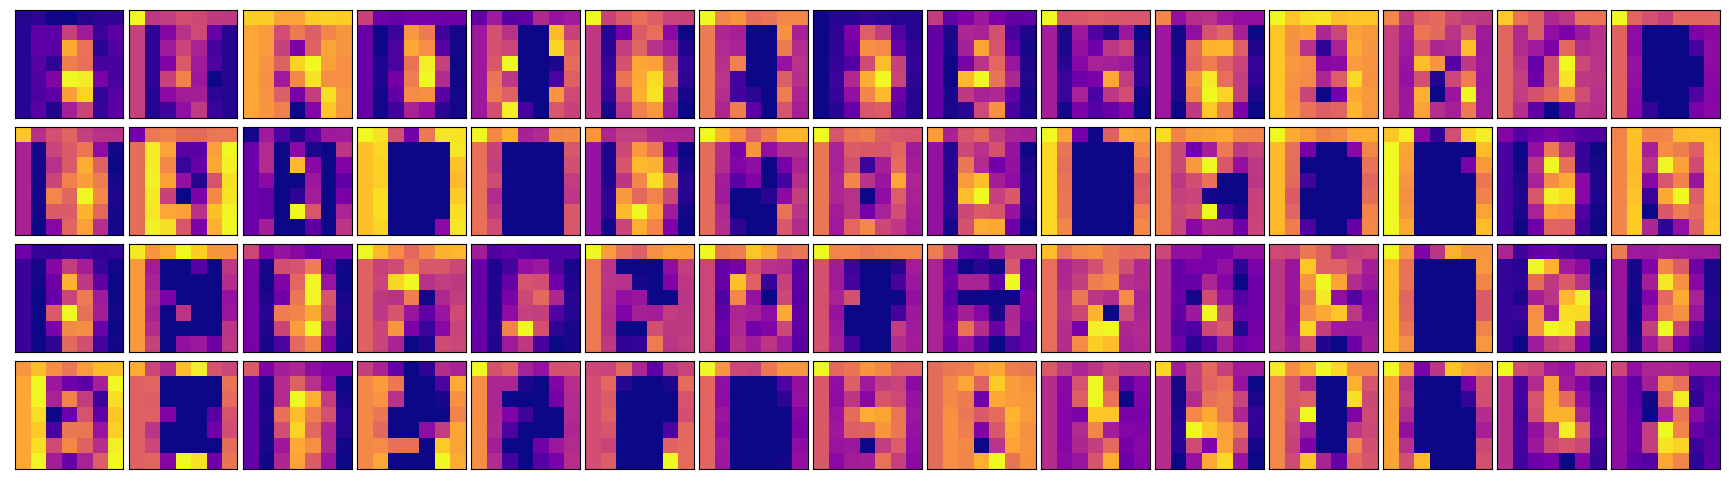

In [345]:
fig = plt.figure(figsize=(22, 6))
for img in range(60):
    ax = fig.add_subplot(4, 15, img+1)
    ax = plt.imshow(activations[39][0, :, :, img], cmap='plasma')
    plt.xticks([])
    plt.yticks([])
    fig.subplots_adjust(wspace=0.05, hspace=0.05)

In [346]:
# get positive sample that it predicted correctly
correct_pred = np.where((y_pred > 0.9) & (y_test == 1))[0]
entries = test_df.loc[correct_pred]

random_idx = np.random.choice(entries.index)

sample = test_df.loc[random_idx]
x = sample['molimage']
x = np.expand_dims(x, axis=0)

### `Visualizing using Grad-CAM`

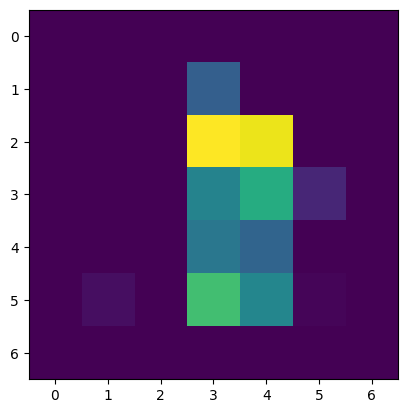

In [347]:
import keras.backend as K

flower_output = model.output[:, 0]
last_conv_layer = model.get_layer('mixed2')

grads = K.gradients(flower_output, last_conv_layer.output)[0]                              
pooled_grads = K.mean(grads, axis=(0, 1, 2))                                               
                                                                                          
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([x])

#2048 is the number of filters/channels in 'mixed10' layer
for i in range(288):                                                                      
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]                          

heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap = np.maximum(heatmap, 0)                                                           
heatmap /= np.max(heatmap)

plt.imshow(heatmap)

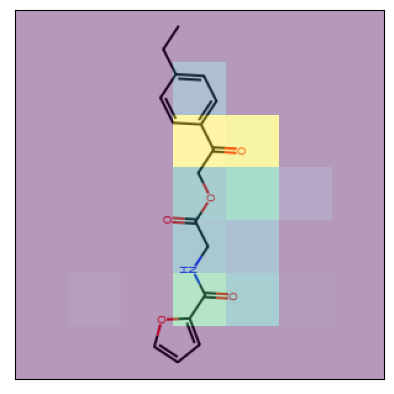

In [348]:
from rdkit.Chem import Draw
import cv2
img = Draw.MolToImage(sample['mol'], size=(300, 300))
img = np.array(img)
img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
# img = x[0]
extent = 0, 80, 0, 80
fig = plt.Figure(frameon=False)

img1 = plt.imshow(img, extent=extent)
img2 = plt.imshow(heatmap, cmap='viridis', alpha=0.4, extent=extent)



plt.xticks([])
plt.yticks([])
plt.show()

# `Comparing other models`

### Random Forest
Random forest is one of the most prominent models in the field of machine learning, especially in tabular data.

The feauturization method that will be used will be `Circular Fingerprints (CFP).`

In [349]:
from sklearn.ensemble import RandomForestClassifier
from deepchem.feat import CircularFingerprint

print("Featurizing train dataset...")
featurizer = CircularFingerprint(size=1024)
X_train, y_train = featurizer.featurize(train_df["smiles"]), train_df["label"]
X_test, y_test = featurizer.featurize(test_df["smiles"]), test_df["label"]

print("Fitting Random Forest model...")
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)
rf.fit(X_train, y_train)


Featurizing train dataset...
Fitting Random Forest model...


RandomForestClassifier(max_depth=10, random_state=0)

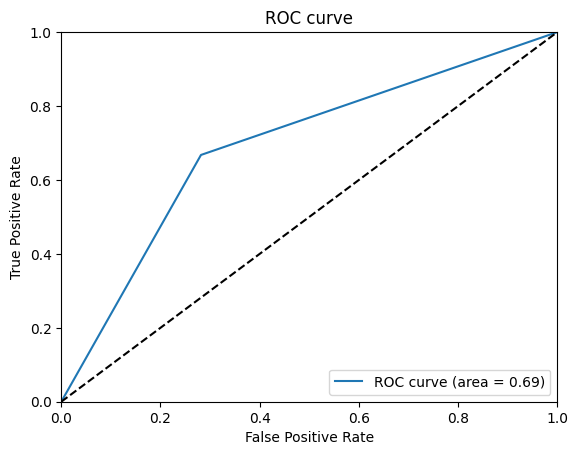

In [350]:
rf_roc_auc = roc_auc_score(y_test, rf.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, rf.predict(X_test))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % rf_roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

### Graph Convolutional Network

* https://www.researchgate.net/publication/317732180_Chemception_A_Deep_Neural_Network_with_Minimal_Chemistry_Knowledge_Matches_the_Performance_of_Expert-developed_QSARQSPR_Models
* https://pubchem.ncbi.nlm.nih.gov/bioassay/686978